### 1. Setting Up Python Environment

In [1]:
%pip install cjm_psl_utils cjm_pil_utils cjm_torchvision_tfms distinctipy
%pip install torch torchvision numpy pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
import math
import random
import multiprocessing
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt

import datetime
from pathlib import Path

from dataset import SpectrogramDataset, move_data_to_device, collate_fn

import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.v2 as transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
from cjm_psl_utils.core import download_file  # if needed
from cjm_pil_utils.core import resize_img, stack_imgs
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor
from distinctipy import distinctipy


# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

### 2. Prepare Dataset: Spectrograms + LabelMe JSON

In [4]:
# Root folder: spectrograms/<class>/*.png + matching .json
SPECT_DIR = Path('spectrograms')


png_files = list(SPECT_DIR.rglob('*.png'))
img_dict = {p.stem: str(p) for p in png_files}

records = []
for jp in SPECT_DIR.rglob('*.json'):
    data = json.load(open(jp))
    records.append({'image_id': jp.stem, 'shapes': data.get('shapes', [])})
annotation_df = pd.DataFrame.from_records(records).set_index('image_id')
annotation_df = annotation_df.loc[annotation_df.index.intersection(img_dict.keys())]

In [5]:
# class names and mapping
all_labels = annotation_df['shapes'].explode().dropna().apply(lambda s: s['label'])
class_names = ['background'] + sorted(all_labels.unique().tolist())
class_to_idx = {c: i for i, c in enumerate(class_names)}

# check if all labels are presented successfully
pd.DataFrame(class_names, columns=['class_name'])


,class_name
0,background
1,airplane
2,car-horn
3,chainsaw
4,engine
5,fireworks
6,hand-saw
7,helicopter
8,siren
9,train


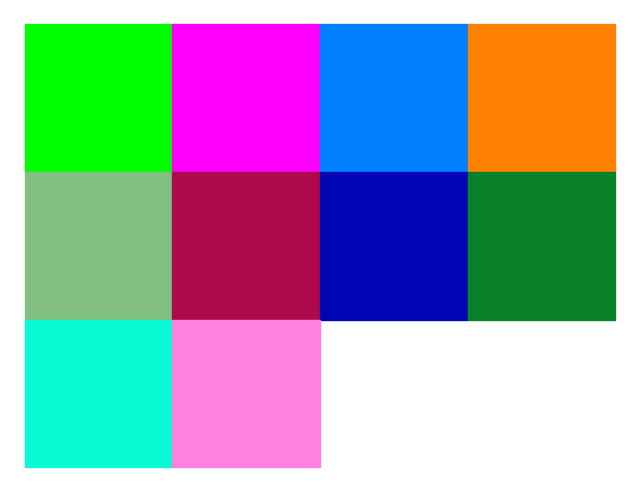

In [6]:
# Build & visualize a color map (include background)
colors     = distinctipy.get_colors(len(class_names))
int_colors = [tuple(int(c*255) for c in color) for color in colors]
distinctipy.color_swatch(colors)

In [7]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


In [8]:
# Split train/val
img_keys = annotation_df.index.tolist()
random.shuffle(img_keys)
split = int(0.8 * len(img_keys))
train_keys, val_keys = img_keys[:split], img_keys[split:]

print(f"Training on {len(train_keys)} samples, validating on {len(val_keys)} samples")

Training on 288 samples, validating on 72 samples


### 3. Dataset and Transforms

In [9]:
# Set training image size
train_sz = 512

# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(
    min_scale=0.3, max_scale=1.0,
    min_aspect_ratio=0.5, max_aspect_ratio=2.0,
    sampler_options=[0.0,0.1,0.3,0.5,0.7,0.9,1.0],
    trials=400, jitter_factor=0.25
)
resize_max = ResizeMax(max_sz=train_sz)
pad_sq    = PadSquare(shift=True, fill=0)

# Data augmentation pipeline
data_aug = transforms.Compose([
    iou_crop,
    transforms.ColorJitter(
        brightness=(0.875, 1.125),
        contrast=(0.5, 1.5),
        saturation=(0.5, 1.5),
        hue=(-0.05, 0.05)
    ),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
])

# Resize and pad pipeline
resize_pad = transforms.Compose([
    resize_max,
    pad_sq,
    transforms.Resize([train_sz, train_sz], antialias=True),
])

# Final normalization and bounding box sanitization
finalize = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Combined transforms
train_tfms = transforms.Compose([data_aug, resize_pad, finalize])
val_tfms   = transforms.Compose([resize_pad, finalize])


# Instantiate the datasets
train_ds = SpectrogramDataset(
    keys       = train_keys,
    df         = annotation_df,
    img_map    = img_dict,
    cls2idx    = class_to_idx,
    transforms = train_tfms
)
val_ds = SpectrogramDataset(
    keys       = val_keys,
    df         = annotation_df,
    img_map    = img_dict,
    cls2idx    = class_to_idx,
    transforms = val_tfms
)

print(f"Train samples: {len(train_ds)},  Val samples: {len(val_ds)}")

loader_params = {
    'batch_size': 4,
    'num_workers': multiprocessing.cpu_count()//2,
    'pin_memory': True,
    'persistent_workers': True,
    'collate_fn': collate_fn,
}

train_loader = DataLoader(train_ds, shuffle=True,  **loader_params)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_params)


print(f"Train batches: {len(train_loader)},  Val batches: {len(val_loader)}")


Train samples: 288,  Val samples: 72
Train batches: 72,  Val batches: 18


### Visualize a Sample Labeled Spectrogram

Image Dims: (310, 308)


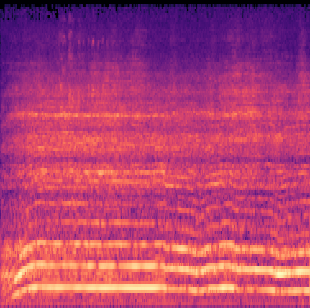

In [10]:
file_id    = list(img_dict.keys())[16]

# Load & show the spectrogram
sample_img = Image.open(img_dict[file_id]).convert('RGB')
print(f"Image Dims: {sample_img.size}")
display(sample_img)

## Inspect the corresponding annotation data

In [11]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,4-149294-B-41
shapes,"[{'label': 'chainsaw', 'points': [[4.080882352941185, 8.411764705882371], [306.2867647058823, 9.14705882352943], [308.4903622978167, 307.0], [1.875000000000007, 305.47058823529414]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}, 'mask': None}]"


### Define a function to convert segmentation polygons to images

In [12]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)

    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

### Annotate the sample image

In [13]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

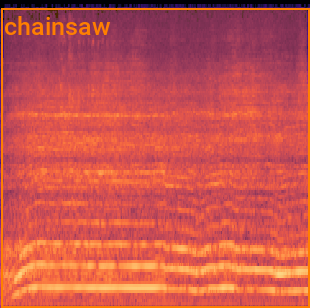

In [14]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]

# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]

# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img),
    masks=masks,
    alpha=0.3,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=bboxes,
    labels=labels,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)


### Load & Adapt MaskRCNN for Spectrogram

In [15]:
# Load COCO‐pretrained Mask R-CNN v2
weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model   = maskrcnn_resnet50_fpn_v2(weights=weights)


num_classes = len(class_names) + 1  # background + my sound labels
# box predictor
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_channels=in_features_box,
    num_classes=num_classes
)
# mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer    = model.roi_heads.mask_predictor.conv5_mask.out_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_channels=in_features_mask,
    dim_reduced=hidden_layer,
    num_classes=num_classes
)

# 4.3 Move to device & dtype
model.to(device=device, dtype=dtype)

print(f"✅ MaskRCNN ready with {num_classes-1} spectrogram classes (plus background)")


✅ MaskRCNN ready with 10 spectrogram classes (plus background)


Testing on: spectrograms/helicopter/1-181071-B-40.png


/opt/anaconda3/envs/geospatial/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


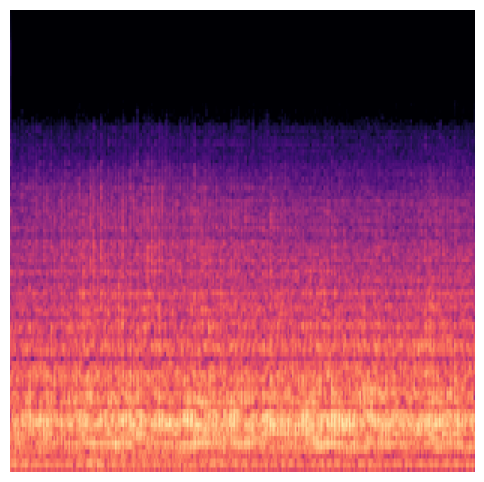

In [16]:
# test image
file_id    = val_keys[0]
test_path  = img_dict[file_id]
print("Testing on:", test_path)

# load & preprocess
image      = Image.open(test_path).convert("RGB")
to_tensor  = transforms.Compose([transforms.ToTensor()])
img_tensor = to_tensor(image).to(device)

# inference
model.eval()
with torch.no_grad():
    outputs = model([img_tensor])

# unpack
boxes  = outputs[0]['boxes'].cpu()
scores = outputs[0]['scores'].cpu()
labels = outputs[0]['labels'].cpu()

# draw on copy of PIL image
vis = image.copy()
draw = ImageDraw.Draw(vis)
threshold = 0.5

for box, score, lbl in zip(boxes, scores, labels):
    if score < threshold:
        continue
    x0,y0,x1,y1 = box.tolist()
    draw.rectangle([x0,y0,x1,y1], outline="red", width=2)
    # map label idx back to your class_names
    cls_idx = lbl.item() - 1  # subtract background
    cls_name = class_names[cls_idx] if 0 <= cls_idx < len(class_names) else f"cls{lbl.item()}"
    draw.text((x0, y0), f"{cls_name}: {score:.2f}", fill="red")

# show
plt.figure(figsize=(6,6))
plt.imshow(vis)
plt.axis("off")
plt.show()


### Fine-Tune the Model

In [17]:
# %% [markdown]
# ### 6. Define Training Loop

# %%
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    model.train() if is_training else model.eval()
    total_loss = 0
    pbar = tqdm(total=len(dataloader), desc=("Train" if is_training else "Eval"))
    for batch_idx, (imgs, targets) in enumerate(dataloader):
        imgs = torch.stack(imgs).to(device)
        # forward
        with autocast(device_type=device.type):
            if is_training:
                losses = model(imgs, move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(imgs, move_data_to_device(targets, device))
            loss = sum(losses.values())
        # backward + step
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                lr_scheduler.step()
                optimizer.zero_grad()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
        total_loss += loss.item()
        pbar.set_postfix({'loss':loss.item(), 'avg':total_loss/(batch_idx+1)})
        pbar.update()
    pbar.close()
    return total_loss / len(dataloader)

def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):
    scaler = GradScaler() if (device.type=='cuda' and use_scaler) else None
    best_val = float('inf')
    for epoch in range(epochs):
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, True)
        val_loss   = run_epoch(model, valid_dataloader, None, None,      device, scaler, epoch, False)
        print(f"Epoch {epoch}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), checkpoint_path)
    if device.type!='cpu':
        torch.cuda.empty_cache()


In [18]:
project_name = 'musa6950-final-modelcheck'
project_dir  = Path(f"./{project_name}/")
project_dir.mkdir(parents=True, exist_ok=True)

# give the model a name (used in the filename)
model.name = "urbansoundpollution-detection"

# timestamp folder
timestamp      = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
checkpoint_dir = project_dir / timestamp
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# full path to your .pth
checkpoint_path = checkpoint_dir / f"{model.name}.pth"
print("Checkpoints will be saved to:", checkpoint_path)

Checkpoints will be saved to: musa6950-final-modelcheck/2025-04-23_03-22-53/urbansoundpollution-detection.pth


In [ ]:
# 6.1 Define optimizer & scheduler
lr         = 5e-4
epochs     = 40
optimizer  = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    total_steps=epochs * len(train_loader)
)

# 6.2 Call your training loop
train_loop(
    model            = model,
    train_dataloader = train_loader,
    valid_dataloader = val_loader,
    optimizer        = optimizer,
    lr_scheduler     = lr_scheduler,
    device           = device,
    epochs           = epochs,
    checkpoint_path  = checkpoint_path,  # from earlier
    use_scaler       = True
)


Train:   0%|          | 0/72 [00:00<?, ?it/s]